### Importing necessary libraries

In [114]:
import time
import warnings
import numpy as np
from numpy import array, zeros, diag, dot
import matplotlib.pyplot as plt
import pandas as pd

plt.rcParams["figure.figsize"] = (12,5)
warnings.filterwarnings("ignore")
pd.set_option('display.precision', 10)
pd.set_option('display.max_colwidth', None)

### Setting stop criterion function and value

In [115]:
TOLERANCE = 10**(-6)

stop_criterion = lambda A, b, x : np.linalg.norm(A @ x - b) / np.linalg.norm(b)

### Additional functions

In [125]:
# Function helps to check whether an input matrix is diagonal dominant
# (for each row verify if absolute value of diagonal is bigger than the sum of all other values)

def diag_dominant_check(diagonal, not_diagonal, necessary=False):
    # diagonal value
    D = np.sum(np.abs(diagonal), axis=1)
    # sum of all other values in the row
    S = np.sum(np.abs(not_diagonal), axis=1)
    
    if necessary:
            print('>> A sufficient (but not necessary) condition for the method to converge')
    if not np.all(D > S):
        print('\033[91m' + '\33[1m' + '   Matrix is NOT strictly diagonally dominant' + '\033[0m')
        if not (np.all(D >= S) and np.any(D > S)):
            print('\033[91m' + '\33[1m' + '   Matrix is NOT irreducibly diagonally dominant' + '\033[0m')
            return False
        print('   Matrix is irreducibly diagonally dominant')
        return True
    print('   Matrix is strictly diagonally dominant')
    return True
    # OUTPUT: True if matrix is diagonal dominant, else False

In [126]:
def spectral_radius_check(diagonal, not_diagonal):
    # diagonal inverse D^(-1)
    inv_D = np.linalg.inv(diagonal)
    # D^(-1) * (L+U)
    eigenvalues = np.linalg.eigvals(inv_D @ not_diagonal)
    eigenvalues = np.absolute(eigenvalues)
    
    print('>> Necessary condition for the method to converge')
    # spectral radius
    if not eigenvalues.max() < 1:
        print('\033[91m' + '\33[1m' + '   Spectral radius of the matrix is bigger than 1' + '\033[0m')
        return False
    print('   Spectral radius of the matrix is smaller than 1')
    return True

In [118]:
# Function helps to check whether an input matrix is symmetric and positive definite

def sym_pos_definite_check(matrix):
    # symmetric check
    trans_matrix = matrix.transpose()
    if not (matrix.shape == trans_matrix.shape and (matrix == trans_matrix).all())\
    or not (np.all(np.linalg.eigvals(matrix) > 0)): # definite check
        print('\033[91m' + '\33[1m' + '   Matrix is NOT symmetric and positive definite' + '\033[0m')
        return False
    print('   Matrix is symmetric and positive definite')
    return True
    # OUTPUT: True if matrix is symmetric positive definite, else False

In [119]:
# Function helps to plot evolution of errors for each method

def plot_errors(jacobi_errors, gauss_errors, Y):       
    plt.plot(jacobi_errors, color="indianred", label="Jacobi method")
    plt.plot(gauss_errors, color="teal", label="Gauss-Seidel method")
    plt.title("Errors (Y = " + str(Y) + ")")
    plt.xlabel('Iteration')
    plt.ylabel('Error value')
    plt.legend()
    plt.show()

### Jacobi method ([link](https://en.wikipedia.org/wiki/Jacobi_method) for the source)

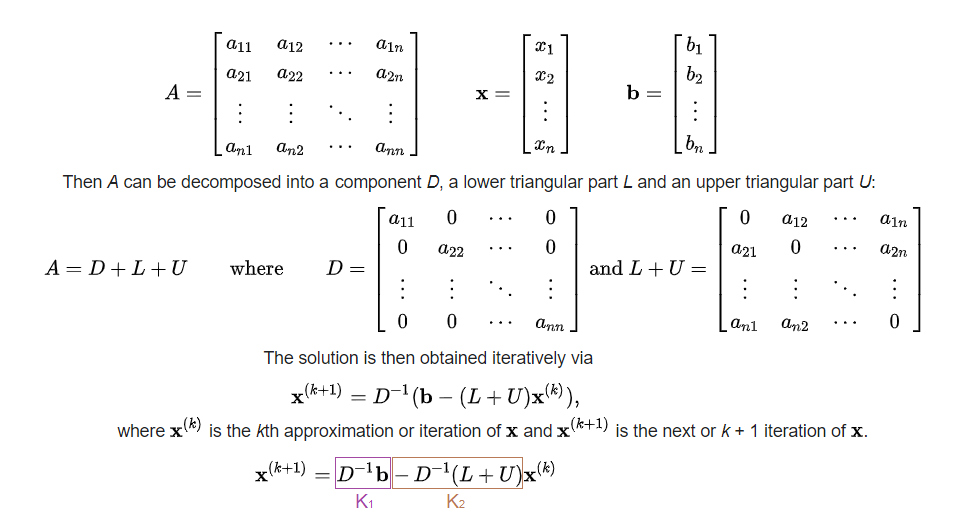

In [120]:
class JacobiMethod:
    def __init__(self, Y):
        # upper matrix triangular
        self.U = np.diag([-1.0 for i in range(1, 20)], 1)
        # lower matrix triangular
        self.L = np.diag([-1.0 for i in range(1, 20)], -1)
        # matrix diagonal
        self.D = np.diag([Y for i in range(0, 20)])
        # whole input matrix
        self.A = self.U + self.D + self.L
        # input vector b
        self.b = np.array([Y-1 if (i==0 or i==19) else Y-2 for i in range(0, 20)])
        # initialization of a future output
        self.x = np.zeros(len(self.b))
        
    def count_result(self):
        # remembering the first solution
        solutions = [self.x]
        
        # checking sufficient (but not necessary) convergence condition
        diag_dominant_check(self.D, self.U + self.L, True)
        
        # checking standard convergence condition
        if not spectral_radius_check(self.D, self.U + self.L):
            return solutions, None, None, None
        
        global TOLERANCE
        # input vector b
        b = self.b
        # input matrix A
        A = self.A
        # diagonal inverse D^(-1)
        inv_D = np.linalg.inv(self.D)
        # input matrix without diagonal (L+U)
        not_D = self.L + self.U
        # K1
        k1 = inv_D @ b
        # K2
        k2 = - inv_D @ not_D

        # array with errors evolution
        errors = []
        
        startTime = time.time()
        
        while(True):
            # the main iteration formula
            self.x = k1 + k2 @ self.x
            
            # checking if the solution pass though stop condition
            error = stop_criterion(A, b, self.x)
            if error < TOLERANCE:
                break
            
            # remembering all of the solution and error values
            solutions.append(self.x)
            errors.append(error)
        
        endTime = time.time()
        
        # OUTPUT: all solutions, all error values, number of iterations, execution time for solution finding
        return solutions, errors, len(errors), (endTime - startTime)*1000

### Gauss–Seidel method ([link](https://en.wikipedia.org/wiki/Gauss%E2%80%93Seidel_method) for the source)

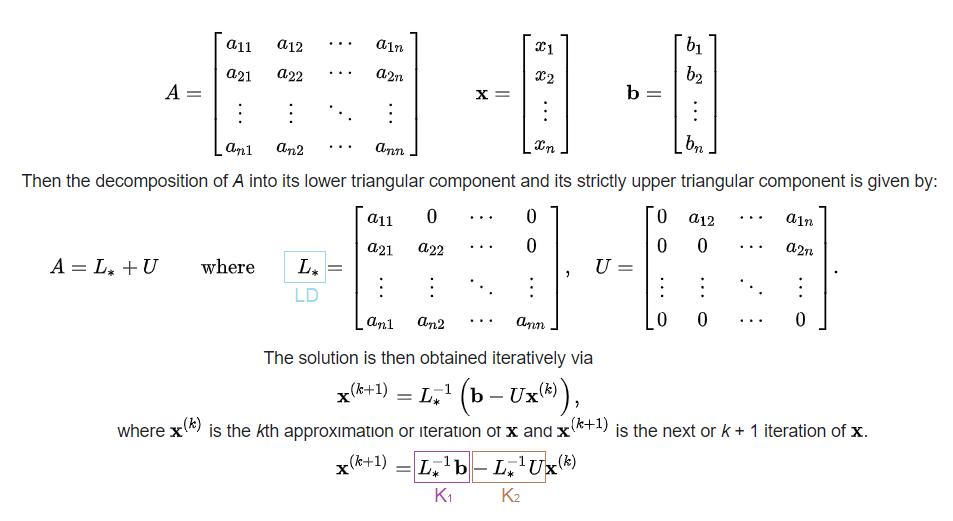

In [124]:
class GaussSeidelMethod:
    def __init__(self, Y):
        # upper matrix triangular
        self.U = np.diag([-1.0 for i in range(1, 20)], 1)
        # lower matrix triangular
        self.L = np.diag([-1.0 for i in range(1, 20)], -1)
        # matrix diagonal
        self.D = np.diag([Y for i in range(0, 20)])
        # whole input matrix
        self.A = self.U + self.D + self.L
        # input vector b
        self.b = np.array([Y-1 if (i==0 or i==19) else Y-2 for i in range(0, 20)])
        # initialization of a future output
        self.x = np.zeros(len(self.b))
        
    def count_result(self):   
        # remembering the first solution
        solutions = [self.x]
        
        print('>> Any necessary condition for the method to converge')
        # checking convergence condition
        if not (diag_dominant_check(self.D, self.U + self.L) or sym_pos_definite_check(self.A)):
            return solutions, None, None, None
        
        global TOLERANCE
        # input vector b
        b = self.b
        # upper matrix (A) triangular
        U = self.U
        # lower matrix (A) triangular with its diagonal
        LD = self.L + self.D
        # inverse (L+D)^(-1)
        inv_LD = np.linalg.inv(LD)
        # K1
        k1 = inv_LD @ b
        # K2
        k2 = - inv_LD @ U
        
        # array with errors evolution
        errors = []
        
        startTime = time.time()
        
        while(True):
            # the main iteration formula
            self.x = k1 + k2 @ self.x
            
            # checking if the solution pass though stop condition
            error = stop_criterion(self.A, b, self.x)
            if error < TOLERANCE:
                break
            
            # remembering all of the solution and error values
            solutions.append(self.x)
            errors.append(error)
        
        endTime = time.time()
        
        # OUTPUT: all solutions, all error values, number of iterations, execution time for solution finding
        return solutions, errors, len(errors), (endTime - startTime)*1000

### Testing for a solution

>> Y = 10
>> Jacobi method
>> A sufficient (but not necessary) condition for the method to converge
   Matrix is strictly diagonally dominant
>> Necessary condition for the method to converge
   Spectral radius of the matrix is smaller than 1
>> Gauss-Seidel method
>> Any necessary condition for the method to converge
   Matrix is strictly diagonally dominant


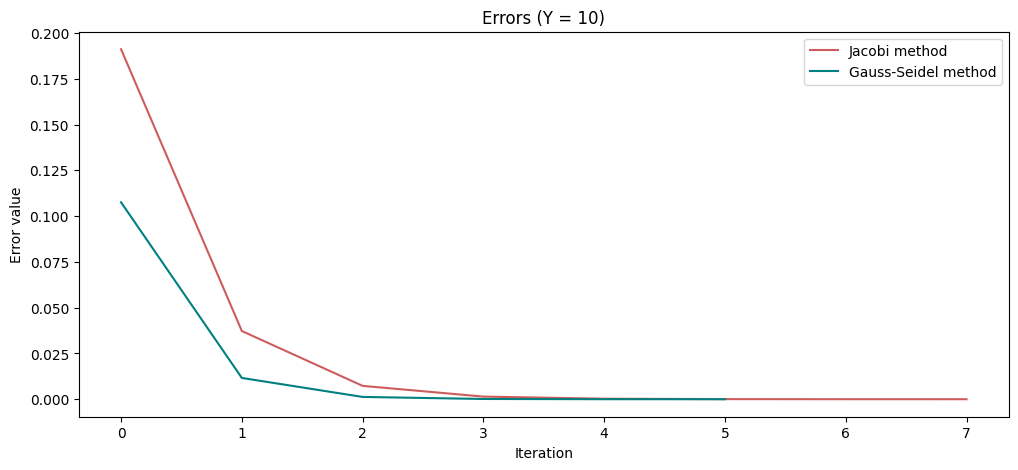

>> Y = 2
>> Jacobi method
>> A sufficient (but not necessary) condition for the method to converge
   Matrix is NOT strictly diagonally dominant
   Matrix is irreducibly diagonally dominant
>> Necessary condition for the method to converge
   Spectral radius of the matrix is smaller than 1
>> Gauss-Seidel method
>> Any necessary condition for the method to converge
   Matrix is NOT strictly diagonally dominant
   Matrix is irreducibly diagonally dominant


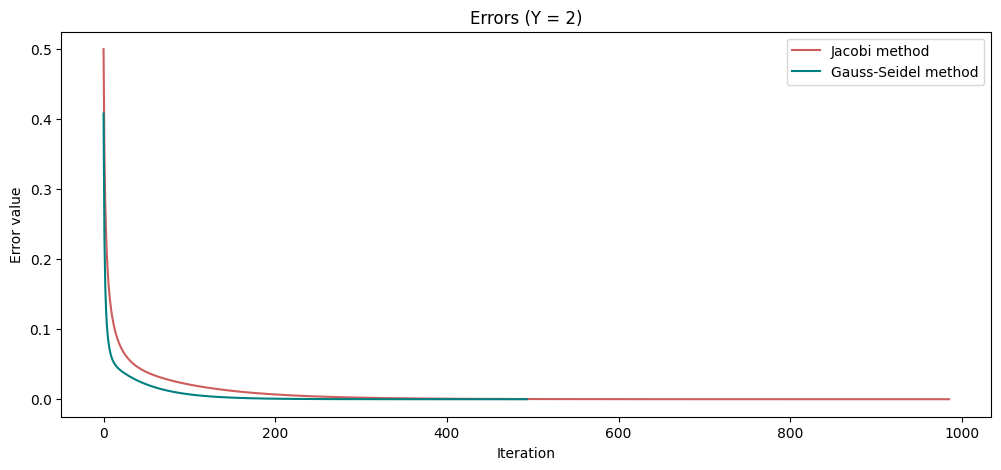

>> Y = 0.8
>> Jacobi method
>> A sufficient (but not necessary) condition for the method to converge
   Matrix is NOT strictly diagonally dominant
   Matrix is NOT irreducibly diagonally dominant
>> Necessary condition for the method to converge
   Spectral radius of the matrix is bigger than 1
>> Gauss-Seidel method
>> Any necessary condition for the method to converge
   Matrix is NOT strictly diagonally dominant
   Matrix is NOT irreducibly diagonally dominant
   Matrix is NOT symmetric and positive definite


In [127]:
# output of all methods
metrics = pd.DataFrame({'Method': pd.Series(dtype='str'),
                        'Y parameter': pd.Series(dtype='float'),
                        'Number of iterations': pd.Series(dtype='int'),
                        'Duration (ms)': pd.Series(dtype='float'),
                        'Min error': pd.Series(dtype='float'), 
                        'Solution': pd.Series(dtype='str')})

# trying each value of input Y parameter
for Y in [10, 2, 4/5]:
    print('\033[1m' + ">> Y = " + str(Y) + '\033[0m')
    # run Jacobi method
    print('\033[1m' + ">> Jacobi method" + '\033[0m')
    jacobi = JacobiMethod(Y)
    solutions, jacobi_errors, iteration, duration = jacobi.count_result()
    # remember its output
    m = {'Method':"Jacobi", 'Y parameter':Y, 'Number of iterations':iteration, 'Duration (ms)':duration, 
        'Min error': jacobi_errors[-1] if jacobi_errors else None, 'Solution':jacobi.x}
    metrics = metrics.append(m, ignore_index = True)
    
    # run Gauss-Seidel method
    print('\033[1m' + ">> Gauss-Seidel method" + '\033[0m')
    gauss = GaussSeidelMethod(Y)
    solutions, gauss_errors, iteration, duration = gauss.count_result()
    # remember its output
    m = {'Method':"Gauss-Seidel", 'Y parameter':Y, 'Number of iterations':iteration, 'Duration (ms)':duration, 
        'Min error': gauss_errors[-1] if gauss_errors else None, 'Solution':gauss.x}
    metrics = metrics.append(m, ignore_index = True)
    
    # plot error values evolution for the certain Y parameter
    if jacobi_errors and gauss_errors:
        plot_errors(jacobi_errors, gauss_errors, Y)

In [123]:
# check the outputs
display(metrics)

,Method,Y parameter,Number of iterations,Duration (ms),Min error,Solution
0,Jacobi,10.0,8,0.999212265,0.0000021601,"[0.999999874, 0.999999748, 0.9999996640000001, 0.9999995800000001, 0.999999544, 0.999999508, 0.9999994990000001, 0.99999949, 0.9999994890000001, 0.999999488, 0.999999488, 0.9999994890000001, 0.99999949, 0.9999994990000001, 0.999999508, 0.999999544, 0.9999995800000001, 0.9999996640000001, 0.999999748, 0.999999874]"
1,Gauss-Seidel,10.0,6,0.0,0.0000015715,"[0.9999998141548001, 0.9999997935058101, 0.999999791211589, 0.9999997909566979, 0.9999997909283806, 0.9999997909252349, 0.9999997909248856, 0.9999997909248468, 0.9999997909248426, 0.999999790924842, 0.9999997909248419, 0.9999997909248419, 0.999999790924842, 0.999999890924842, 0.9999999620359531, 0.9999999899371876, 0.9999999978373248, 0.999999999615118, 0.9999999999446505, 0.9999999999944651]"
2,Jacobi,2.0,986,14.9977207184,0.0000010081,"[0.9999970971846016, 0.9999942592133025, 0.9999915494816918, 0.9999890285206962, 0.9999867526444182, 0.9999847726921735, 0.999983132892823, 0.9999818698767751, 0.9999810118577206, 0.9999805780023879, 0.9999805780023879, 0.9999810118577206, 0.9999818698767751, 0.999983132892823, 0.9999847726921735, 0.9999867526444182, 0.9999890285206962, 0.9999915494816918, 0.9999942592133025, 0.9999970971846016]"
3,Gauss-Seidel,2.0,494,6.9994926453,0.0000010144,"[0.999996841896895, 0.9999938240994499, 0.9999910105271081, 0.9999884591428578, 0.9999862207979802, 0.9999843382604359, 0.9999828454443949, 0.9999817668535547, 0.9999811172458659, 0.9999809015221932, 0.9999811148364107, 0.9999817429195673, 0.999982762606167, 0.9999841425463811, 0.999985844084245, 0.9999878222786416, 0.9999900270412208, 0.9999924043633805, 0.9999948976030755, 0.9999974488015377]"
4,Jacobi,0.8,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"
5,Gauss-Seidel,0.8,None,None,None,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]"


### Conclusion

Both methods performance are displayed above. As we may notice, **Gauss-Seidel method has a better performance in comparison to the Jacobi**. 
- For `Y=10` Gauss-Seidel method finds a solution in less iterations (*6*) and its performance is faster (almost *0 ms* when Jacobi needs approximately *1 ms*). Final solution error is also smaller for Gauss-Seidel method.
- Similarly, for `Y=2` Jacobi method needs almost twice as much iteration (*986 iterations*) and time (*~ 24 ms*) as the Gauss-Seidel (*494 iterations* and *~ 11.5 ms*). That is why the second method is more effective even with the fact, that its error value is little bit bigger (approximately *10.081 * 10(-7)* in comparison to *10.144 * 10(-7)*).
- For `Y=0.8` both methods diverge (input does not fulfill the condition), so we can not find a solution.
- In addition, we may point out from the graph that Gauss-Seidel method reduce the value of error faster than the Jacobi.